# TensorFlow

Case study: Houses for sale

## Setup

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

print(tf.__version__)
sns.set_theme(style="ticks", color_codes=True)

2.7.1


## Data preparation

- See notebook ["Data"](https://kirenz.github.io/regression/docs/case-duke-exploration.html) for details about data preprocessing

In [4]:
from case_duke_data_prep import *

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 97
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   price       97 non-null     int64   
 1   bed         97 non-null     int64   
 2   bath        97 non-null     float64 
 3   area        97 non-null     int64   
 4   year_built  97 non-null     int64   
 5   cooling     97 non-null     category
 6   lot         97 non-null     float64 
dtypes: category(1), float64(2), int64(4)
memory usage: 5.5 KB


# Simple regression

- We start with a single-variable linear regression, to predict price from area.

In [6]:
# Select features for simple regression
features = ['area']
X = df[features]

X.info()
print("Missing values:",X.isnull().any(axis = 1).sum())

# Create response
y = df["price"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 97
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   area    97 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB
Missing values: 0


## Data splitting

In [18]:
val_dataframe = df.sample(frac=0.2, random_state=1337)
train_dataframe = df.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 78 samples for training and 19 for validation


## Data preprocessing

In [21]:
def dataframe_to_dataset(dataframe):
    dataframe = df.copy()
    labels = dataframe.pop("price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [22]:
# Use function
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [23]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [24]:
from tensorflow.keras.layers import Normalization

# Define numerical preprocessing function
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

In [25]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import StringLookup

# Define categorical preprocessing function
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [26]:
# Categorical features encoded as integers
area = keras.Input(shape=(1,), name="area", dtype="int64")

In [27]:
all_inputs = [
    area,
]

In [28]:
area_encoded = encode_categorical_feature(area, "area", train_ds, False)


In [29]:
all_features = layers.concatenate(
    [
        area_encoded,
    ]
)

## Model

In [30]:
# 1
x = layers.Dense(32, activation="relu")(all_features)
# 2
x = layers.Dropout(0.5)(x)
# 3
output = layers.Dense(1, activation="sigmoid")(x)
# 4
model = keras.Model(all_inputs, output)

In [31]:
model.compile(optimizer="adam", 
              loss ="binary_crossentropy", 
              metrics=["accuracy"])

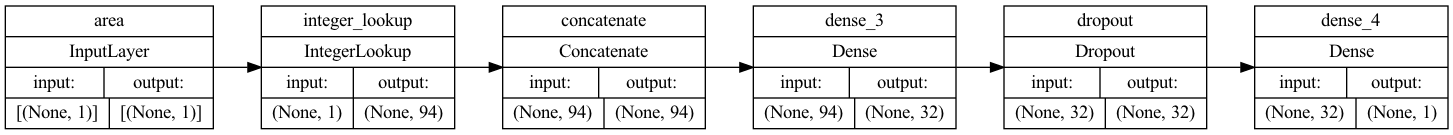

In [32]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Training

In [33]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/Users/jankirenz/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['bed', 'bath', 'year_built', 'cooling', 'lot'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


4/4 [==============================] - 1s 116ms/step - loss: 13274.2012 - accuracy: 0.0000e+00 - val_loss: 6606.3564 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 12ms/step - loss: -2061.6497 - accuracy: 0.0000e+00 - val_loss: -7055.6055 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 39ms/step - loss: -19544.6230 - accuracy: 0.0000e+00 - val_loss: -20524.9043 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 17ms/step - loss: -18927.0469 - accuracy: 0.0000e+00 - val_loss: -33759.1484 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 13ms/step - loss: -28394.1953 - accuracy: 0.0000e+00 - val_loss: -46967.5586 - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 18ms/step - loss: -53396.4141 - accuracy: 0.0000e+00 - val_loss: -60052.3984 - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 10ms/step - loss: -7

## Linear regression


- Training a model with tf.keras typically starts by defining the model architecture.

- In this case use a keras.Sequential model. This model represents a sequence of steps. In this case there is only one step:

  - Apply a linear transformation to produce 1 output using layers.Dense.


  
- The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

Build the sequential model:

In [10]:
model = keras.Sequential([
        layers.Dense(units=1, activation="relu"),
        layers.Dense(1)
    ])
    
model.compile(optimizer="rmsprop", 
              loss="mse", 
              metrics=["mae"])


In [13]:
histroy = model.fit(X_train, y_train,
          epochs=130, 
          batch_size=16,
          validation_split = 0.2, 
          verbose=0)


In [14]:
          
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 29ms/step - loss: 355388719104.0000 - mae: 535959.8750


In [15]:
test_mae_score

535959.875

In [17]:
predictions = model.predict(X_test)
predictions[0]

array([4487.9917], dtype=float32)

- Once the model is built, configure the training procedure using the Model.compile() method.

- The most important arguments to compile are the loss and the optimizer since these define what will be optimized (mean_absolute_error) and how (using the optimizers.Adam).

In [9]:
lm.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error'
)

- Once the training is configured, use Model.fit() to execute the training:

In [22]:
%%time

history = lm.fit(
    X_train, y_train,
    epochs=200,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 4.63 s, sys: 386 ms, total: 5.01 s
Wall time: 5.39 s


In [23]:
y_train

49    525000
71    540000
69    105000
15    610000
39    535000
       ...  
61    580000
72    650000
14    631500
93    541000
51    725000
Name: price, Length: 77, dtype: int64

In [24]:
# Calculate R squared
y_pred = lm.predict(X_train).astype(np.int64)

r2_score(y_train, y_pred)  

-7.042298800162028

In [25]:
# slope coefficient
lm.layers[0].kernel

<tf.Variable 'dense_2/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-1.0806017]], dtype=float32)>

Visualize the model's training progress using the stats stored in the history object.

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
195,552219.375,630846.2500,195
196,552213.875,630840.0000,196
197,552208.375,630833.6875,197
198,552202.875,630827.3750,198
199,552197.375,630821.0000,199


In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [price]')
  plt.legend()
  plt.grid(True)

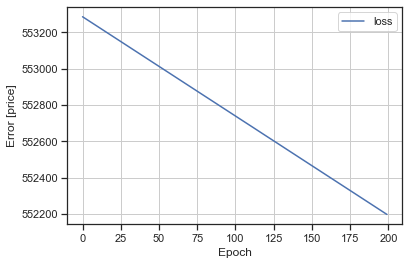

In [28]:
plot_loss(history)

Collect the results (mean squared error) on the test set, for later:

In [29]:
test_results = {}

test_results['lm'] = lm.evaluate(
    X_test,
    y_test, verbose=0)

test_results

{'lm': 543700.625}

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [30]:
x = tf.linspace(0.0, 6200, 6201)
y = lm.predict(x)

y

array([[ 3.9999834e-01],
       [-6.8060338e-01],
       [-1.7612051e+00],
       ...,
       [-6.6971694e+03],
       [-6.6982500e+03],
       [-6.6993306e+03]], dtype=float32)

In [31]:
def plot_area(x, y):
  plt.scatter(X_train['area'], y_train, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('area')
  plt.ylabel('price')
  plt.legend()

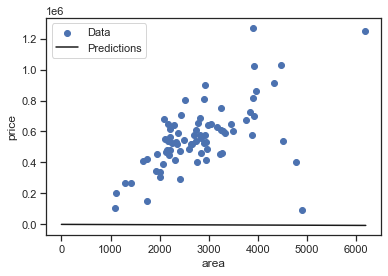

In [32]:
plot_area(x,y)

# Multiple Regression

In [ ]:
# Select all relevant features
features= [
 'bed',
 'bath',
 'area',
 'year_built',
 'cooling',
 'lot'
  ]
X = df[features]

# Convert categorical to numeric
X = pd.get_dummies(X, columns=['cooling'], prefix='cooling', prefix_sep='_')

X.info()
print("Missing values:",X.isnull().any(axis = 1).sum())

# Create response
y = df["price"]

In [ ]:
from sklearn.model_selection import train_test_split

# Train Test Split
# Use random_state to make this notebook's output identical at every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lm_2 = tf.keras.Sequential([
    layers.Dense(units=1, input_shape=(7,))
])

lm_2.summary()

In [ ]:
lm_2.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [111]:
%%time

history = lm_2.fit(
    X_train, y_train,
    epochs=500,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2
)

CPU times: user 6.7 s, sys: 430 ms, total: 7.13 s
Wall time: 6.52 s


In [112]:
# Calculate R squared
y_pred = lm_2.predict(X_train).astype(np.int64)
y_true = y_train.astype(np.int64)

r2_score(y_train, y_pred)  

0.008066631014296388

In [113]:
# slope coefficients
lm_2.layers[0].kernel

<tf.Variable 'dense_14/kernel:0' shape=(7, 1) dtype=float32, numpy=
array([[93.865845],
       [95.36067 ],
       [93.04233 ],
       [92.90618 ],
       [95.016266],
       [96.31462 ],
       [87.34802 ]], dtype=float32)>

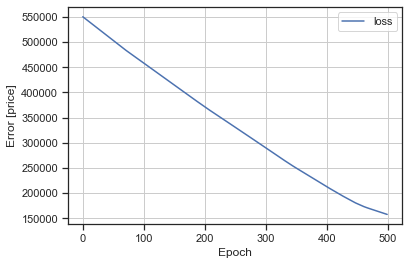

In [114]:
plot_loss(history)

In [115]:
test_results['lm_2'] = lm_2.evaluate(
    X_test, y_test, verbose=0)

# DNN regression

This model will contain a few more layers than the previous model:

- Two hidden, nonlinear, Dense layers using the relu nonlinearity.
- A linear single-output layer.

In [116]:
dnn_model = keras.Sequential([
      layers.Dense(units=1, input_shape=(7,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [117]:
%%time

history = dnn_model.fit(
    X_train, y_train,
    epochs=500,
    verbose=0,
    validation_split = 0.2)

CPU times: user 7.19 s, sys: 494 ms, total: 7.69 s
Wall time: 6.91 s


In [118]:
# Calculate R squared
y_pred = dnn_model.predict(X_train).astype(np.int64)
y_true = y_train.astype(np.int64)

r2_score(y_train, y_pred)  

0.3319246298888

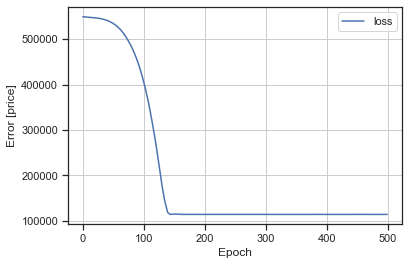

In [119]:
plot_loss(history)

In [120]:
test_results['dnn_model'] = dnn_model.evaluate(
    X_test, y_test, verbose=0)

# Performance comparison

In [121]:
pd.DataFrame(test_results, index=['Mean absolute error [price]']).T

,Mean absolute error [price]
lm,537925.625000
lm_2,145734.390625
dnn_model,103795.859375
